In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
# from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from prophet import Prophet
from sklearn.metrics import r2_score

In [25]:

data = pd.read_csv('CleanData.csv')

In [26]:
data.drop(['Row ID', 'Order ID', 'Ship Date',
       'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'City', 'State',
       'Country', 'Region', 'Market', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Quantity', 'Discount', 'Profit',
       'Shipping Cost', 'Order Priority', 'Year', 'Month', 'Weekday',
       'IsWeekend', 'Season', 'PromotionFlag', 'DiscountCategory'],axis=1,inplace=True)

In [27]:
data['Order Date'] = pd.to_datetime(data['Order Date'])
data.groupby("Order Date")["Sales"].sum().reset_index()
data["ds"] = data['Order Date']
data["y"] = data["Sales"].astype(float)
data.head()

,Order Date,Sales,ds,y
0,2014-11-11,221.980000,2014-11-11,221.980000
1,2014-02-05,581.495063,2014-02-05,581.495063
2,2014-10-17,581.495063,2014-10-17,581.495063
3,2014-01-28,581.495063,2014-01-28,581.495063
4,2014-11-05,581.495063,2014-11-05,581.495063


In [28]:
results = []

<h3 style="color:#70C1B3; font-weight:bold">Arima Model</h3>

In [29]:
'''y_series = data.set_index("ds")["y"]
arima_model = auto_arima(y_series, seasonal=False, stepwise=True, suppress_warnings=True)
arima_pred = arima_model.predict_in_sample()
arima_r2 = r2_score(y_series, arima_pred)
results.append(("ARIMA_date_only", {
    "MSE": np.sqrt(mean_squared_error(y_series, arima_pred)),
    "MAE": mean_absolute_error(y_series, arima_pred),
    "R2": arima_r2
}))'''

'y_series = data.set_index("ds")["y"]\narima_model = auto_arima(y_series, seasonal=False, stepwise=True, suppress_warnings=True)\narima_pred = arima_model.predict_in_sample()\narima_r2 = r2_score(y_series, arima_pred)\nresults.append(("ARIMA_date_only", {\n    "MSE": np.sqrt(mean_squared_error(y_series, arima_pred)),\n    "MAE": mean_absolute_error(y_series, arima_pred),\n    "R2": arima_r2\n}))'

<h3 style="color:#70C1B3; font-weight:bold">Exponential Smoothing (ETS)</h3>

In [30]:
y_series = data.set_index("ds")["y"]
ets_model = ExponentialSmoothing(y_series, trend="add", seasonal=None)
ets_fit = ets_model.fit()
ets_pred = ets_fit.fittedvalues
ets_r2 = r2_score(y_series, ets_pred)
results.append(("ETS_date_only", {
    "MSE": np.sqrt(mean_squared_error(y_series, ets_pred)),
    "MAE": mean_absolute_error(y_series, ets_pred),
    "R2": ets_r2
}))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<h3 style="color:#70C1B3; font-weight:bold">Models that can also take features</h3>

In [31]:
data_encoded = pd.read_csv('EncodedData.csv')
data_encoded.head()

,Order Date,Year,Month,Weekday,IsWeekend,Sales,Country,PromotionFlag,Product ID,Segment_Consumer,...,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables,Category_Furniture,Category_Office Supplies,Category_Technology,Season_Fall,Season_Spring,Season_Summer,Season_Winter
0,2012-01-01,2012,1,6,True,408.300,2,0,2732,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2012-01-01,2012,1,6,True,113.670,6,1,513,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2012-01-01,2012,1,6,True,55.242,6,1,2151,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,2012-01-01,2012,1,6,True,120.366,6,1,2801,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,2012-01-01,2012,1,6,True,66.120,65,0,2722,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [32]:
X_all = data_encoded.drop(columns=["Sales", "Order Date"])
y_all = data_encoded["Sales"]

In [33]:
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X_all):
    pass
X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]

<h3 style="color:#70C1B3; font-weight:bold">Random Forest Model</h3>

In [34]:
rf = RandomForestRegressor()
gs_rf = GridSearchCV(rf, {
    "n_estimators": [50, 100],
    "max_depth": [5, 10]
})
gs_rf.fit(X_train, y_train)
y_rf_pred = gs_rf.predict(X_test)
rf_r2 = r2_score(y_test, y_rf_pred)
results.append(("RandomForest_all_features", {
    "MSE": np.sqrt(mean_squared_error(y_test, y_rf_pred)),
    "MAE": mean_absolute_error(y_test, y_rf_pred),
    "R2": rf_r2
}))


<h3 style="color:#70C1B3; font-weight:bold">Gradient Boosting</h3>

In [35]:
imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

gb = GradientBoostingRegressor()
gs_gb = GridSearchCV(gb, {
    "n_estimators": [50, 100],
    "learning_rate": [0.05, 0.1]
})
gs_gb.fit(X_train, y_train)
y_gb_pred = gs_gb.predict(X_test)
gb_r2 = r2_score(y_test, y_gb_pred)
results.append(("GradientBoosting_all_features", {
    "MSE": np.sqrt(mean_squared_error(y_test, y_gb_pred)),
    "MAE": mean_absolute_error(y_test, y_gb_pred),
    "R2": gb_r2
}))

<h3 style="color:#70C1B3; font-weight:bold">Prophet</h3>

In [ ]:
monthly_sales = data.groupby(data['ds'].dt.to_period("M"))['Sales'].sum().reset_index()
monthly_sales['ds'] = monthly_sales['ds'].dt.to_timestamp()
monthly_sales.rename(columns={'Sales': 'y'}, inplace=True)

train = monthly_sales[:-12]
test = monthly_sales[-12:]
model = Prophet()
model.fit(train)
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

forecast['ds'] = pd.to_datetime(forecast['ds']).dt.date
test['ds'] = pd.to_datetime(test['ds']).dt.date
y_pred = forecast[['ds', 'yhat']].tail(12)['yhat'].values
y_test = test['y'].values

In [ ]:
print(len(y_test), len(y_pred))


In [ ]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

<h3 style="color:#70C1B3; font-weight:bold">LTSM</h3>

In [36]:
X_seq = []
y_seq = []
window = 10
for i in range(len(X_all) - window):
    X_seq.append(X_all[i:i+window])
    y_seq.append(y_all.values[i+window])

X_seq = np.array(X_seq).astype(np.float32)
y_seq = np.array(y_seq).astype(np.float32)
if y_seq.ndim > 1 and y_seq.shape[1] == 1:
    y_seq = y_seq.flatten()

split_index = int(len(X_seq) * 0.8)
X_seq_train, X_seq_test = X_seq[:split_index], X_seq[split_index:]
y_seq_train, y_seq_test = y_seq[:split_index], y_seq[split_index:]

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit( X_seq_train, y_seq_train, epochs=10, batch_size=32, verbose=1, callbacks=[EarlyStopping(patience=3)])
y_lstm_pred = model_lstm.predict(X_seq_test)
lstm_r2 = r2_score(y_seq_test, y_lstm_pred.flatten())
results.append(("LSTM_all_features", {
    "MSE": np.sqrt(mean_squared_error(y_seq_test, y_lstm_pred.flatten())),
    "MAE": mean_absolute_error(y_seq_test, y_lstm_pred.flatten()),
    "R2": lstm_r2
}))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 49953.2305
Epoch 2/10
   7/1281 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 35491.4570  

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1281/1281 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 35504.5586
Epoch 3/10
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 35698.7734
Epoch 4/10
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 35083.9023
Epoch 5/10
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 34899.6641
Epoch 6/10
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 35118.4258
Epoch 7/10
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 34784.7148
Epoch 8/10
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 35126.8984
Epoch 9/10
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 34888.9961
Epoch 10/10
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 35091.4492
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<h3 style="color:#70C1B3; font-weight:bold">Comparison</h3>

In [37]:

results_df = pd.DataFrame(results, columns=["Model", "Metrics"])
results_df[["MSE", "MAE", "R2"]] = results_df["Metrics"].apply(pd.Series)
results_df.drop(columns=["Metrics"], inplace=True)
print("\nModel Comparison Results:\n")
print(results_df.sort_values("MSE"))


Model Comparison Results:

                           Model         MSE         MAE        R2
1      RandomForest_all_features  123.764991   89.188546  0.581130
2  GradientBoosting_all_features  133.493335   97.150812  0.512693
0                  ETS_date_only  134.684438   89.090729  0.498011
3              LSTM_all_features  188.151057  152.467804  0.040771


In [38]:

improved_results = []

<h3 style="color:#70C1B3; font-weight:bold">Improved Random Forest</h3>

In [39]:

rf = RandomForestRegressor(random_state=42)
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}
rs_rf = RandomizedSearchCV(
    rf, rf_param_grid, n_iter=20, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42
)

rs_rf.fit(X_train, y_train)
y_rf_pred = rs_rf.predict(X_test)
rf_r2 = r2_score(y_test, y_rf_pred)
improved_results.append(("RandomForest_all_features", {
    "MSE": np.sqrt(mean_squared_error(y_test, y_rf_pred)),
    "MAE": mean_absolute_error(y_test, y_rf_pred),
    "R2": rf_r2
}))

<h3 style="color:#70C1B3; font-weight:bold">Improved Gradient Boosting</h3>

In [40]:
gb = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "subsample": [0.8, 1.0]
}
rs_gb = RandomizedSearchCV(
    gb, gb_param_grid, n_iter=20, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42
)
rs_gb.fit(X_train, y_train)
y_gb_pred = rs_gb.predict(X_test)
gb_r2 = r2_score(y_test, y_gb_pred)
improved_results.append(("GradientBoosting_all_features", {
    "MSE": np.sqrt(mean_squared_error(y_test, y_gb_pred)),
    "MAE": mean_absolute_error(y_test, y_gb_pred),
    "R2": gb_r2
}))

<h3 style="color:#70C1B3; font-weight:bold">Improved Models Comparison</h3>

In [41]:
improved_results_df = pd.DataFrame(improved_results, columns=["Model", "Metrics"])
improved_results_df[["MSE", "MAE", "R2"]] = improved_results_df["Metrics"].apply(pd.Series)
improved_results_df.drop(columns=["Metrics"], inplace=True)
print("\nModel Comparison After Improving Results:\n")
print(improved_results_df.sort_values("MSE"))


Model Comparison After Improving Results:

                           Model         MSE        MAE        R2
1  GradientBoosting_all_features  112.618759  80.856763  0.653180
0      RandomForest_all_features  134.748221  98.076346  0.503488


In [42]:
improved_results = []

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    "n_estimators": [100, 200,300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [1, 2],
    "subsample": [0.8, 1.0],
    "max_features": ["sqrt", "log2", None]
}

rs_gb = RandomizedSearchCV(
    gb,
    gb_param_grid,
    n_iter=25,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1
)
rs_gb.fit(X_train, y_train)
y_gb_pred = rs_gb.predict(X_test)

gb_r2 = r2_score(y_test, y_gb_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_gb_pred))
gb_mae = mean_absolute_error(y_test, y_gb_pred)

improved_results.append((
    "GradientBoosting_all_features_Optimized_25trials",
    {
        "MSE": gb_rmse,
        "MAE": gb_mae,
        "R2": gb_r2
    }
))


Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [44]:
improved_results_df = pd.DataFrame(improved_results, columns=["Model", "Metrics"])
improved_results_df[["MSE", "MAE", "R2"]] = improved_results_df["Metrics"].apply(pd.Series)
improved_results_df.drop(columns=["Metrics"], inplace=True)
print("\nModel Comparison After Improving Results:\n")
print(improved_results_df.sort_values("MSE"))



Model Comparison After Improving Results:

                                              Model         MSE        MAE  \
0  GradientBoosting_all_features_Optimized_25trials  106.497389  73.927479   

         R2  
0  0.689858  


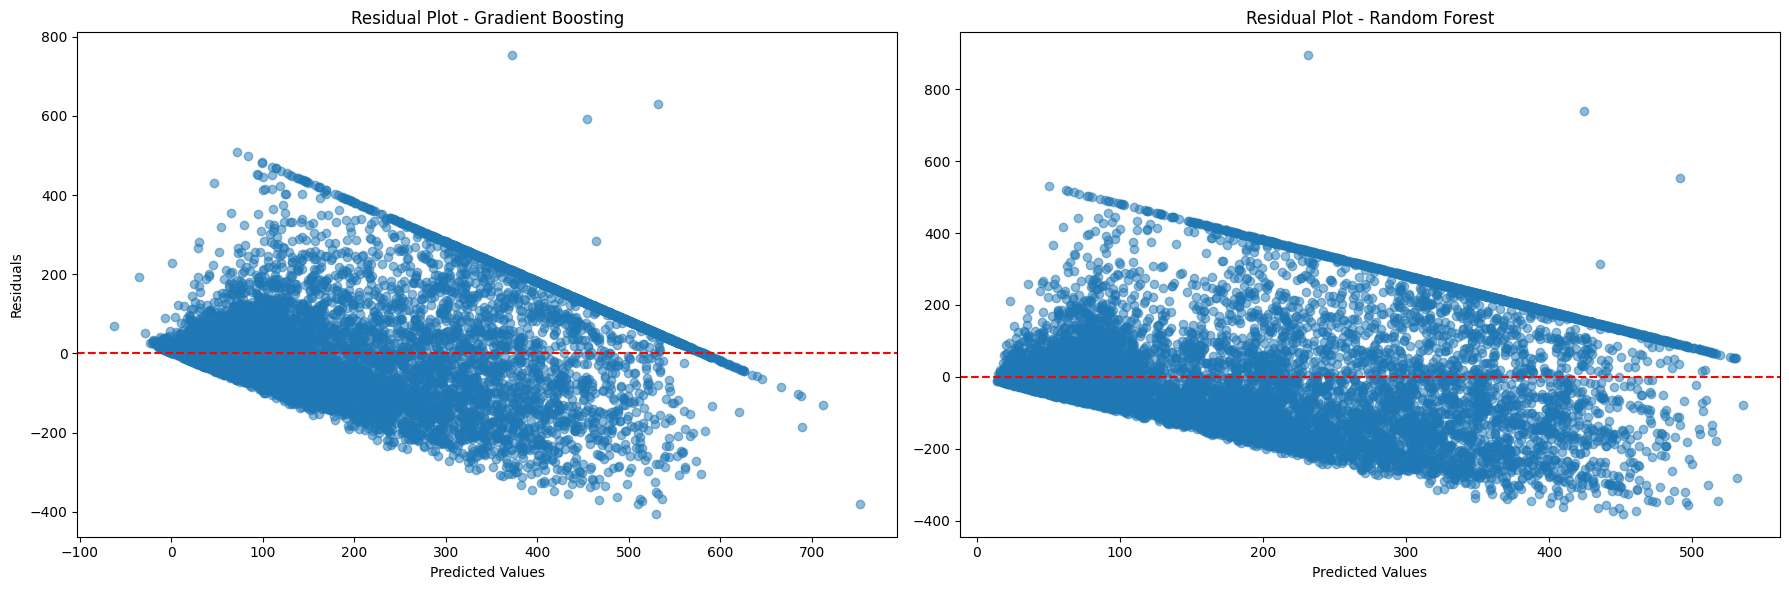

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
residuals_gb = y_test - y_gb_pred
axes[0].scatter(y_gb_pred, residuals_gb, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_title('Residual Plot - Gradient Boosting')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')

residuals_rf = y_test - y_rf_pred
axes[1].scatter(y_rf_pred, residuals_rf, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('Residual Plot - Random Forest')
axes[1].set_xlabel('Predicted Values')

plt.tight_layout()
plt.show()

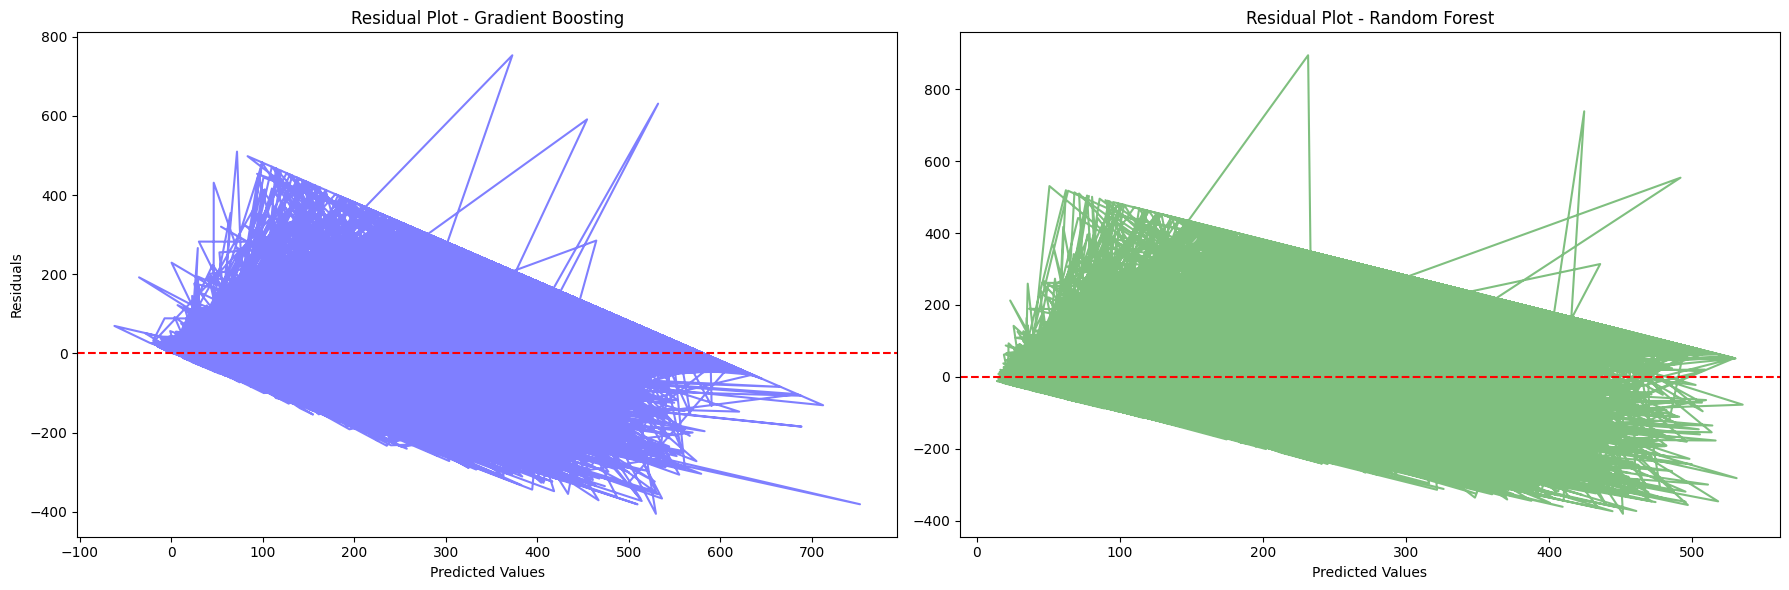

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

residuals_gb = y_test - y_gb_pred
axes[0].plot(y_gb_pred, residuals_gb, 'b-', alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_title('Residual Plot - Gradient Boosting')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')

residuals_rf = y_test - y_rf_pred
axes[1].plot(y_rf_pred, residuals_rf, 'g-', alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('Residual Plot - Random Forest')
axes[1].set_xlabel('Predicted Values')

plt.tight_layout()
plt.show()

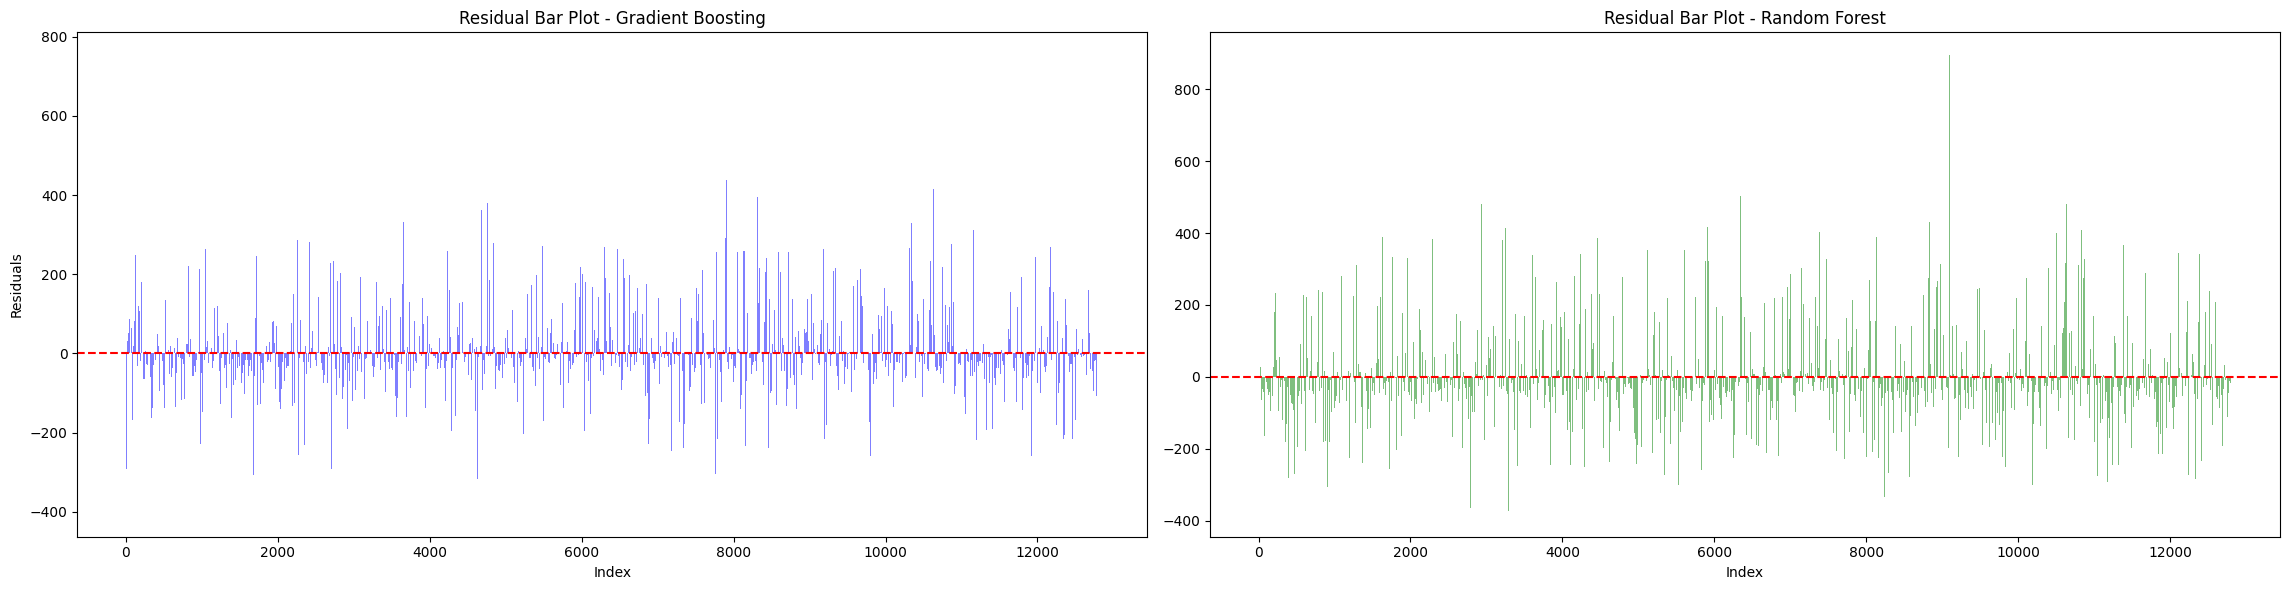

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(23, 6))
residuals_gb = y_test - y_gb_pred
axes[0].bar(np.arange(len(residuals_gb)), residuals_gb, color='b', alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_title('Residual Bar Plot - Gradient Boosting')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Residuals')

residuals_rf = y_test - y_rf_pred
axes[1].bar(np.arange(len(residuals_rf)), residuals_rf, color='g', alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('Residual Bar Plot - Random Forest')
axes[1].set_xlabel('Index')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

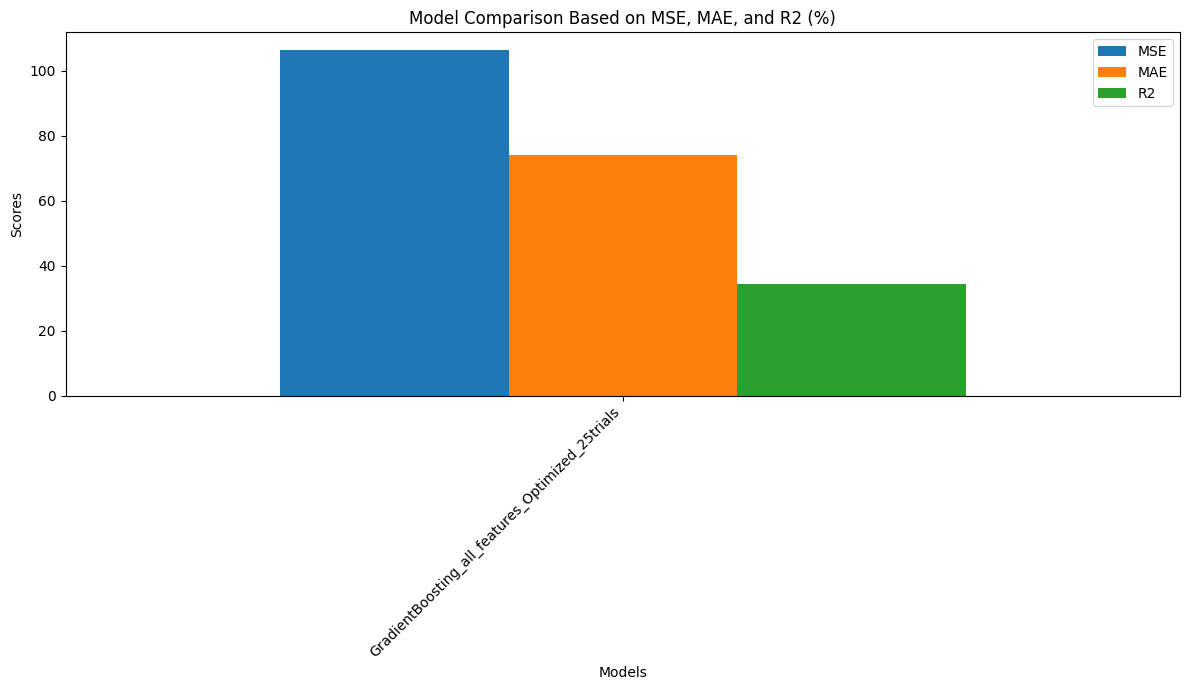

In [53]:
improved_results_df = pd.DataFrame(improved_results, columns=["Model", "Metrics"])

improved_results_df[["MSE", "MAE", "R2"]] = improved_results_df["Metrics"].apply(pd.Series)
improved_results_df.drop(columns=["Metrics"], inplace=True)

improved_results_df["R2"] = improved_results_df["R2"] * 50

improved_results_df = improved_results_df.sort_values("MSE")

plt.figure(figsize=(10, 6))
improved_results_df.set_index('Model')[['MSE', 'MAE', 'R2']].plot(kind='bar', width=0.8, figsize=(12, 7))

plt.title('Model Comparison Based on MSE, MAE, and R2 (%)')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()